In [42]:
# imports & load
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

CSV = "../data/data_files/backtest_bets.csv"
df = pd.read_csv(CSV, parse_dates=["date","month_start"]).sort_values("date")

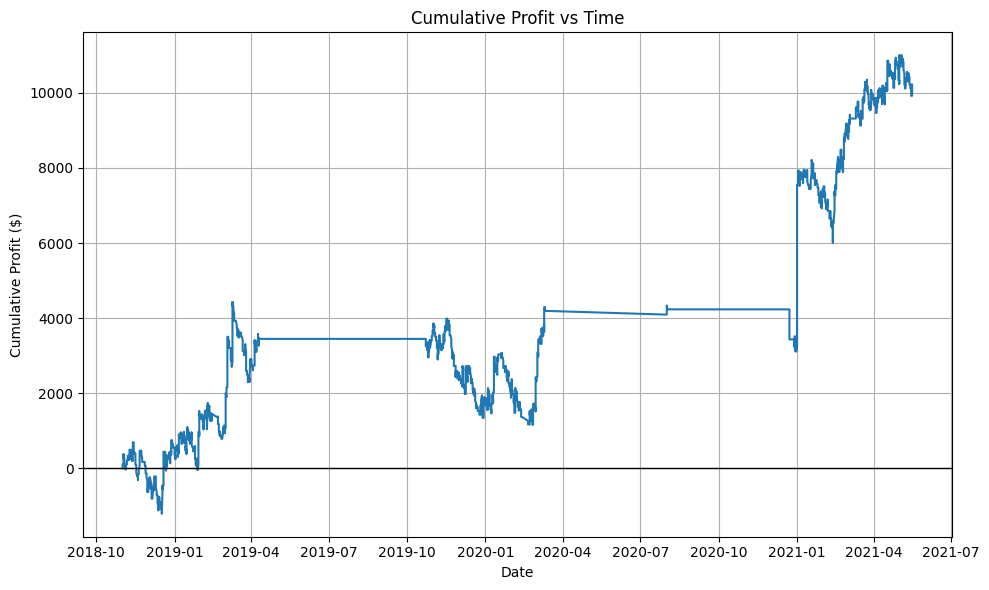

In [43]:
# backtest cumulative profit plot
plt.figure(figsize=(10,6))
df["cum_profit"] = df["profit"].cumsum()
plt.plot(df["date"], df["cum_profit"])
plt.axhline(0, linewidth=1, color='k')
plt.xlabel("Date"); plt.ylabel("Cumulative Profit ($)")
plt.title("Cumulative Profit vs Time")
plt.grid(True); plt.tight_layout(); plt.show()

In [45]:
import pandas as pd
import numpy as np

# --- load backtest bets ---
CSV_PATH = "../data/data_files/backtest_bets.csv"
SEASONS = [2019, 2020, 2021]  # change if needed

df = pd.read_csv(CSV_PATH, parse_dates=["date"])

# add season if missing (Oct–Dec -> next year; Jan–Sep -> same year)
if "season" not in df.columns:
    def season_year(dt: pd.Timestamp) -> int:
        return dt.year + 1 if dt.month >= 10 else dt.year
    df["season"] = df["date"].apply(season_year)

# keep placed bets only and target seasons
bets = df[df["bet_team"].isin(["A","B"])].copy()
bets = bets[bets["season"].isin(SEASONS)]
if bets.empty:
    raise ValueError(f"No placed bets in seasons {SEASONS}.")

# --- per-season stats ---
season_stats = (
    bets.groupby("season")
        .agg(total_profit=("profit", "sum"),
             n_bets=("profit", "count"))
        .assign(ROI=lambda g: g["total_profit"] / (100.0 * g["n_bets"]))
        .reindex(SEASONS)  # keep order
)

# print bets per season
for season, n in season_stats["n_bets"].items():
    print(f"Season {season}: bets placed = {int(n)}")

# average ROI across seasons
avg_roi = season_stats["ROI"].mean()
print(f"Average ROI across {len(SEASONS)} seasons: {avg_roi:.6f}")

# --- 3-year Sharpe scaled by total game days (days with >=1 bet) ---
bets["date_only"] = bets["date"].dt.date
daily = (
    bets.groupby("date_only")
        .agg(profit_sum=("profit", "sum"),
             n_bets=("profit", "count"))
        .assign(daily_ret=lambda g: g["profit_sum"] / (100.0 * g["n_bets"]))
)
daily_ret = daily["daily_ret"].dropna()
n_game_days = len(daily_ret)

if n_game_days == 0:
    three_year_sharpe = np.nan
else:
    mu = daily_ret.mean()
    sigma = daily_ret.std(ddof=1)
    three_year_sharpe = np.nan if sigma == 0 else (mu / sigma) * np.sqrt(n_game_days)
print(f"Sharpe: {three_year_sharpe:.6f}")

Season 2019: bets placed = 303
Season 2020: bets placed = 277
Season 2021: bets placed = 351
Average ROI across 3 seasons: 0.102329
Sharpe: 1.389376
